<a href="https://colab.research.google.com/github/jeenathampi/fpgrowthapriori/blob/master/fpgrowth_and_frequent_pattern_mining_apriori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from mlxtend.preprocessing import TransactionEncoder
!pip install mlxtend --upgrade
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [ ]:
import mlxtend
print(mlxtend.__version__)

0.19.0


In [ ]:
# Load the dataset
groceries_data = pd.read_csv("https://dataminingassignment.s3.amazonaws.com/Groceries_dataset.csv")

In [ ]:
groceries_data.shape

(38765, 3)

In [ ]:
groceries_data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [ ]:
# Get all the transactions as a list of lists
all_transactions = [transaction[1]['itemDescription'].tolist() for transaction in list(groceries_data.groupby(['Member_number', 'Date']))]

In [ ]:
len(all_transactions)

14963

In [ ]:
all_transactions[0:10]

[['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['whole milk', 'pastry', 'salty snack'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['soda', 'pickled vegetables'],
 ['frankfurter', 'curd'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['beef', 'white bread'],
 ['frankfurter', 'soda', 'whipped/sour cream']]

In [ ]:
# The following instructions transform the dataset into the required format 
trans_encoder = TransactionEncoder() # Instanciate the encoder
trans_encoder_matrix = trans_encoder.fit(all_transactions).transform(all_transactions)
trans_encoder_matrix = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_)

In [ ]:
trans_encoder_matrix.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,...,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
def perform_rule_calculation(transact_items_matrix, rule_type="fpgrowth", min_support=0.001):
    start_time = 0
    total_execution = 0
    
    if(not rule_type=="fpgrowth"):
        start_time = time.time()
        rule_items = apriori(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Apriori!")
        
    else:
        start_time = time.time()
        rule_items = fpgrowth(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Fp Growth!")
    
    rule_items['number_of_items'] = rule_items['itemsets'].apply(lambda x: len(x))
    
    return rule_items, total_execution

In [ ]:
def compute_association_rule(rule_matrix, metric="lift", min_thresh=1):
    rules = association_rules(rule_matrix, 
                              metric=metric, 
                              min_threshold=min_thresh)
    
    return rules

In [ ]:
# Plot Lift Vs Coverage(confidence) 
def plot_metrics_relationship(rule_matrix, col1, col2):
    fit = np.polyfit(rule_matrix[col1], rule_matrix[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rule_matrix[col1], rule_matrix[col2], 'yo', rule_matrix[col1], 
    fit_funt(rule_matrix[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

In [ ]:
def compare_time_exec(algo1=list, alg2=list):
    
    execution_times = [algo1[1], algo2[1]]
    algo_names = (algo1[0], algo2[0])
    y=np.arange(len(algo_names))
    
    plt.bar(y,execution_times,color=['yellow', 'blue'])
    plt.xticks(y,algo_names)
    plt.xlabel('Algorithms')
    plt.ylabel('Time')
    plt.title("Execution Time (seconds) Comparison")
    plt.show()

In [ ]:
val = {'name':12}
value = list(val.items())[0]

In [ ]:
value

('name', 12)

#Fp Growph Algorithm

In [ ]:
fpgrowth_matrix, fp_growth_exec_time = perform_rule_calculation(trans_encoder_matrix) # Run the algorithm
print("Fp Growth execution took: {} seconds".format(fp_growth_exec_time))

Computed Fp Growth!
Fp Growth execution took: 0.33831167221069336 seconds


In [ ]:
fpgrowth_matrix.head()

,support,itemsets,number_of_items
0,0.157923,(whole milk),1
1,0.085879,(yogurt),1
2,0.060349,(sausage),1
3,0.009490,(semi-finished bread),1
4,0.051728,(pastry),1


In [ ]:
fpgrowth_matrix.tail()

,support,itemsets,number_of_items
745,0.001403,"(chewing gum, yogurt)",2
746,0.001069,"(chewing gum, other vegetables)",2
747,0.001002,"(chewing gum, soda)",2
748,0.001069,"(whole milk, pasta)",2
749,0.001002,"(rolls/buns, seasonal products)",2


In [ ]:
fp_growth_rule_lift = compute_association_rule(fpgrowth_matrix)

In [ ]:
fp_growth_rule_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(whole milk, rolls/buns)",(yogurt),0.013968,0.085879,0.001337,0.095694,1.114293,0.000137,1.010854
1,"(whole milk, yogurt)",(rolls/buns),0.011161,0.110005,0.001337,0.119760,1.088685,0.000109,1.011083
2,"(rolls/buns, yogurt)",(whole milk),0.007819,0.157923,0.001337,0.170940,1.082428,0.000102,1.015701
3,(whole milk),"(rolls/buns, yogurt)",0.157923,0.007819,0.001337,0.008464,1.082428,0.000102,1.000650
4,(rolls/buns),"(whole milk, yogurt)",0.110005,0.011161,0.001337,0.012151,1.088685,0.000109,1.001002


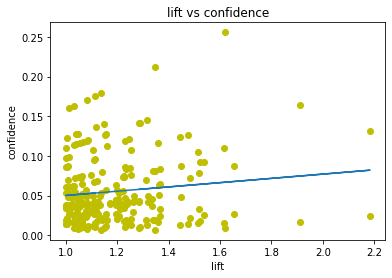

In [ ]:
plot_metrics_relationship(fp_growth_rule_lift, col1='lift', col2='confidence')

In [ ]:
#Confidence
fp_growth_rule = compute_association_rule(fpgrowth_matrix, metric="confidence", min_thresh=0.2)
fp_growth_rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541
1,"(rolls/buns, sausage)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304


#Apriori Algorithm

In [ ]:
apriori_matrix, apriori_exec_time = perform_rule_calculation(trans_encoder_matrix, rule_type="apriori")
print("Apriori Execution took: {} seconds".format(apriori_exec_time))

Computed Apriori!
Apriori Execution took: 2.9502055644989014 seconds


In [ ]:
apriori_matrix.head()

,support,itemsets,number_of_items
0,0.004010,(Instant food products),1
1,0.021386,(UHT-milk),1
2,0.001470,(abrasive cleaner),1
3,0.001938,(artif. sweetener),1
4,0.008087,(baking powder),1


In [ ]:
apriori_matrix.tail()

,support,itemsets,number_of_items
745,0.001136,"(whole milk, rolls/buns, sausage)",3
746,0.001002,"(whole milk, rolls/buns, soda)",3
747,0.001337,"(whole milk, rolls/buns, yogurt)",3
748,0.001069,"(whole milk, soda, sausage)",3
749,0.001470,"(whole milk, yogurt, sausage)",3


In [ ]:
apriori_rule_lift = compute_association_rule(apriori_matrix)

In [ ]:
apriori_rule_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(UHT-milk),(tropical fruit),0.021386,0.067767,0.001537,0.071875,1.060617,8.785064e-05,1.004426
1,(tropical fruit),(UHT-milk),0.067767,0.021386,0.001537,0.022682,1.060617,8.785064e-05,1.001326
2,(beef),(brown bread),0.033950,0.037626,0.001537,0.045276,1.203301,2.597018e-04,1.008012
3,(brown bread),(beef),0.037626,0.033950,0.001537,0.040853,1.203301,2.597018e-04,1.007196
4,(beef),(citrus fruit),0.033950,0.053131,0.001804,0.053150,1.000349,6.297697e-07,1.000020


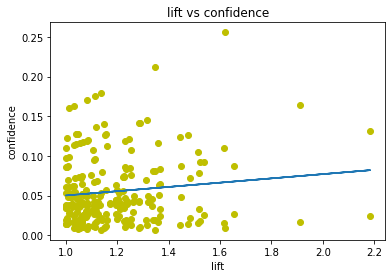

In [ ]:
plot_metrics_relationship(apriori_rule_lift, col1='lift', col2='confidence')

In [ ]:
apripri_rule = compute_association_rule(apriori_matrix, metric="confidence", min_thresh=0.2)
apripri_rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(rolls/buns, sausage)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304
1,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541


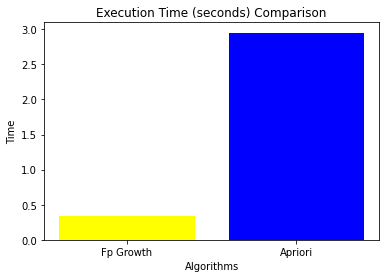

In [ ]:
algo1 = ['Fp Growth', fp_growth_exec_time]
algo2 = ['Apriori', apriori_exec_time]

compare_time_exec(algo1, algo2)